<a href="https://colab.research.google.com/github/ShaliniR8/lahman-mlb/blob/main/combined_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## imports

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
from sklearn import preprocessing
from sklearn import compose
from sklearn import impute
from sklearn import decomposition
from sklearn import model_selection
from sklearn import tree
from sklearn.utils import compute_class_weight
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn import pipeline

In [10]:
%%capture
!pip install xgboost

In [11]:
import xgboost as xgb

In [12]:
#@title Load Dataset

%%capture
# ---- filtered (only from 1910) 
# !wget https://github.com/ShaliniR8/lahman-mlb/raw/main/baseballdatabase.zip
# !unzip /content/baseballdatabase.zip -d "/content/"


#---- full
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/baseballdatabank_2022.zip
!unzip /content/baseballdatabank_2022.zip -d "/content/"

path = "/content/baseballdatabank-2022.2/core/"



In [13]:
batting = pd.read_csv(path + "Batting.csv")
pitching = pd.read_csv(path + "Pitching.csv")
people = pd.read_csv(path + "People.csv")
# fielding = pd.read_csv(path + "Fielding.csv")
teams = pd.read_csv(path + "Teams.csv")

## Dataset

In [14]:
batting = batting[["playerID","yearID","teamID", "H", "BB", "HBP", "AB", "SF", "2B", "3B", "HR"]].copy()
pitching = pitching[["playerID","yearID","teamID", "ERA"]].copy()
people = people[['playerID', 'birthYear']].copy()
teams = teams[['teamID', 'yearID', 'W', 'L', 'R', 'RA', 'G']].copy()
all_dfs = { 
    'batting': batting,
    'pitching': pitching,
    'people':people,
    # 'fielding':fielding,
    'teams':teams
}

## Cleaning

In [60]:

def cleanX(X):
  categorical_features = X.select_dtypes("object").columns.to_list()
  numerical_features = X.select_dtypes(["int64", "float64"]).columns.to_list()
  knnImp = impute.KNNImputer(missing_values=np.nan)
  simpleImp = impute.SimpleImputer(strategy = 'median', missing_values=np.nan)
  Ximputer = compose.ColumnTransformer([
    ('categorical', knnImp, categorical_features),
    ('numerical', simpleImp, numerical_features)
  ])
  X_ = Ximputer.fit_transform(X)

  return X_

In [61]:
for name,df in all_dfs.items():
  not_keys = list(set(df.columns.to_list()) - {'teamID', 'playerID'})
  keys = list(set(df.columns.to_list()) - set(not_keys))
  imputedX = pd.DataFrame(cleanX(df[not_keys]), columns = not_keys, dtype='int64')
  all_dfs[name] = pd.concat([df[keys], imputedX], axis = 1)
  print(name)
  print(all_dfs[name].info())
  


batting
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110495 entries, 0 to 110494
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   teamID    110495 non-null  object
 1   playerID  110495 non-null  object
 2   2B        110495 non-null  int64 
 3   3B        110495 non-null  int64 
 4   HR        110495 non-null  int64 
 5   BB        110495 non-null  int64 
 6   AB        110495 non-null  int64 
 7   H         110495 non-null  int64 
 8   SF        110495 non-null  int64 
 9   HBP       110495 non-null  int64 
 10  yearID    110495 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 9.3+ MB
None
pitching
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49430 entries, 0 to 49429
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   teamID    49430 non-null  object
 1   playerID  49430 non-null  object
 2   ERA       49430 non-null  int64 
 3   yearID 

In a future version, passing float-dtype values and an integer dtype to DataFrame will retain floating dtype if they cannot be cast losslessly (matching Series behavior). To retain the old behavior, use DataFrame(data).astype(dtype)


## Constructing Features

No need to run this after the feature is already constructed 

In [83]:
def win_perc(team, year):
    team_year = teams[(teams['yearID'] == year) & (teams['teamID'] == team)]
    if team_year.empty:
        return np.nan
    team_year = team_year.iloc[0]
    w = team_year['W']
    l = team_year['L']
    return w / (w + l)


def get_rolling_win_perc (row):
    year = row['yearID']
    team = row['teamID']
    row['prev_year_win_perc'], row['rolling_3_win_perc'], row['rolling_5_win_perc'] = np.nan, np.nan, np.nan
    year1 = win_perc(team, year - 1)
    year2 = win_perc(team, year - 2)
    year3 = win_perc(team, year - 3)
    year4 = win_perc(team, year - 4)
    year5 = win_perc(team, year - 5)
    if (year1 == np.nan or year2 == np.nan or year3 == np.nan or year3 == np.nan or year4 == np.nan or year5 == np.nan):
      if (year1 == np.nan or year2 == np.nan or year3 ==np.nan):
        if year1 == np.nan: 
          return row
        else:
          row['prev_year_win_perc'] = year1
          return row
      else:
        row['prev_year_win_perc'], row['rolling_3_win_perc'] = year1,  (year1 + year2 + year3)/3
        return row
    else:
      row['prev_year_win_perc'], row['rolling_3_win_perc'], row['rolling_5_win_perc']  = year1,  (year1 + year2 + year3)/3, (year1 + year2 + year3 + year4 + year5)/5
      return row

def get_pwp(row):
    R = row['R']
    RA = row['RA']
    G = row['G']
    year = row['yearID'] - 1
    team = row['teamID']
    row['pwp'] = np.nan
    new_row = teams[(teams['yearID'] == year) & (teams['teamID'] == team)]
    if new_row.empty: return row
    new_row = new_row.iloc[0]
    row['pwp_1.83'] = np.power((R + RA)/G, 1.83)
    row['pwp_0.285'] = np.power((R + RA)/G, 0.285)
    return row

In [ ]:
def get_age(row):
  playerID = row['playerID']
  yearID = row['yearID']
  birthYear = people[people['playerID'] == playerID]['birthYear']
  birthYear = birthYear.iloc[0]
  age = yearID - birthYear
  row['age'] = age
  return row

In [ ]:
def ops_calc(row):
  #calc done on rows of batting table
  if row['AB'] == 0:
      return np.nan
  HBP = row["HBP"]
  SF = row["SF"]
  singles = row["H"] - row["2B"] - row["3B"] - row["HR"]
  obp = (row["H"] + row["BB"] + HBP) / (row["AB"] + row["BB"] + SF + HBP)
  slug = (singles + (2 * row["2B"]) + (3 * row["3B"]) + (4 * row["HR"])) / row["AB"]
 
  return slug + obp 

def get_ops(row):
  year = row['yearID'] - 1
  team = row['teamID']
  player = row["playerID"]
  row['ops'] = np.nan
  filtered_df = batting[(batting['yearID'] == year) & (batting['teamID'] == team) & (batting['playerID'] == player)]
  if filtered_df.empty:
      return row
  filtered_df = filtered_df.iloc[0]
  row['ops'] = ops_calc(filtered_df)
  return row

In [80]:
teams = all_dfs['teams']
pitching = all_dfs['pitching']
people = all_dfs['people']
batting = all_dfs['batting']

In [84]:
# teams winning perc
t_features = teams.apply(lambda x: get_rolling_win_perc(x), axis = 1)

In [88]:
t_features

,G,L,R,RA,W,prev_year_win_perc,pwp,pwp_0.285,pwp_1.83,rolling_3_win_perc,rolling_5_win_perc,teamID,yearID
0,31,10,401,303,20,NaN,NaN,NaN,NaN,NaN,NaN,BS1,1871
1,28,9,302,241,19,NaN,NaN,NaN,NaN,NaN,NaN,CH1,1871
2,29,19,249,341,10,NaN,NaN,NaN,NaN,NaN,NaN,CL1,1871
3,19,12,137,243,7,NaN,NaN,NaN,NaN,NaN,NaN,FW1,1871
4,33,17,302,313,16,NaN,NaN,NaN,NaN,NaN,NaN,NY2,1871
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2980,162,72,706,672,90,0.517241,NaN,1.840663,50.282121,0.540727,0.533078,SLN,2021
2981,162,62,857,651,100,0.666667,NaN,1.888568,59.300995,0.604938,0.545679,TBA,2021
2982,162,102,625,815,60,0.366667,NaN,1.863895,54.499295,0.420576,0.465926,TEX,2021
2983,162,71,846,663,91,0.533333,NaN,1.888925,59.372978,0.465844,0.483210,TOR,2021


In [87]:
t_features = t_features.apply(lambda x: get_pwp(x), axis = 1)

In [ ]:
#pitcher ages
ages = pitching.apply(lambda x: get_age(x), axis = 1).copy()

In [ ]:
#median era and mean pitching age
p_features = ages.groupby(['teamID', 'yearID']).agg({'ERA':'median', 
                                                            'age':'mean'}).reset_index()
p_features = p_features.rename(columns = {"ERA": "medianERA", 'age': 'pitcherAverageAge'})

In [ ]:
#batter ages
ages = batting.apply(lambda x: get_age(x), axis = 1).copy()

In [ ]:
ops = ages.apply(lambda x: get_ops(x), axis=1).copy()

In [ ]:
#median ops and average age

b_features = ops.groupby(['teamID', 'yearID']).agg({'age':'mean', 
                                                            'ops':'median'}).reset_index()
b_features = b_features.rename(columns = {"age": "batterAverageAge", "ops": "medianOPS"})



## construct target data



In [15]:
y = teams.apply(lambda y: y['W']/ (y['W'] + y['L']), axis=1)


## Load constructed features 

In [16]:
%%capture
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/b_features.csv 
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/p_features.csv 
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/t_features.csv 

In [17]:
b_features = pd.read_csv('/content/b_features.csv').drop(columns = ['Unnamed: 0'])
p_features = pd.read_csv('/content/p_features.csv').drop(columns = ['Unnamed: 0'])
t_features = pd.read_csv('/content/t_features.csv').drop(columns = ['Unnamed: 0'])

In [18]:
cols_to_merge_on = list(set(t_features.columns).intersection(set(p_features.columns)))
print(cols_to_merge_on)
temp1 = pd.merge(t_features, p_features, how='inner', left_on = cols_to_merge_on, right_on = cols_to_merge_on)

['yearID', 'teamID']


In [19]:
cols_to_merge_on = list(set(b_features.columns).intersection(set(temp1.columns)))
features = pd.merge(temp1, b_features, how='inner', left_on=cols_to_merge_on, right_on=cols_to_merge_on)

## preprocess

In [21]:
ohe = preprocessing.OneHotEncoder()
ss = preprocessing.StandardScaler()
year_array = list(set(features['yearID']))
year_array.sort()
mm = preprocessing.MinMaxScaler(feature_range=(0, len(set(features['yearID']))-1))

In [22]:
fcols = list(features.columns)
fcols.remove('teamID')
fcols.remove('yearID')
print(fcols)

['prev_year_win_perc', 'rolling_3_win_perc', 'rolling_5_win_perc', 'pwp_0.285', 'pwp_1.83', 'medianERA', 'pitcherAverageAge', 'batterAverageAge', 'medianOPS']


In [23]:
# perctages and ages std scaled
features_ss = ss.fit_transform(features[fcols])
features[fcols] = features_ss

In [24]:
# scaling down year
ymm = mm.fit_transform(features[['yearID']]).astype('int64')
ymm = ymm.reshape(1, -1)[0]
features['yearID'] = pd.Series(ymm)

In [25]:
# one hot encoding teamID
teamID = features[['teamID']]
teamID_ohe = ohe.fit_transform(teamID)
tid_names = list(ohe.get_feature_names_out())
teamID_df = pd.DataFrame(teamID_ohe.toarray(), columns= tid_names, dtype = 'int64')
features = features.drop(columns = ['teamID'])
X = pd.concat([teamID_df, features], axis = 1)

In [27]:
y = list(y)

In [26]:
X.head()

,teamID_ALT,teamID_ANA,teamID_ARI,teamID_ATL,teamID_BAL,teamID_BFN,teamID_BFP,teamID_BL1,teamID_BL2,teamID_BL3,...,yearID,prev_year_win_perc,rolling_3_win_perc,rolling_5_win_perc,pwp_0.285,pwp_1.83,medianERA,pitcherAverageAge,batterAverageAge,medianOPS
0,0,0,0,0,0,0,0,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,0.975867,0.246971,-1.187270,NaN
1,0,0,0,0,0,0,0,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,-1.182682,-0.568166,-1.430563,NaN
2,0,0,0,0,0,0,0,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,0.975867,-1.057247,-2.612721,NaN
3,0,0,0,0,0,0,0,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,1.515504,-2.524493,-9.164149,NaN
4,0,0,0,0,0,0,0,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,6.911877,-0.785535,-0.700682,NaN


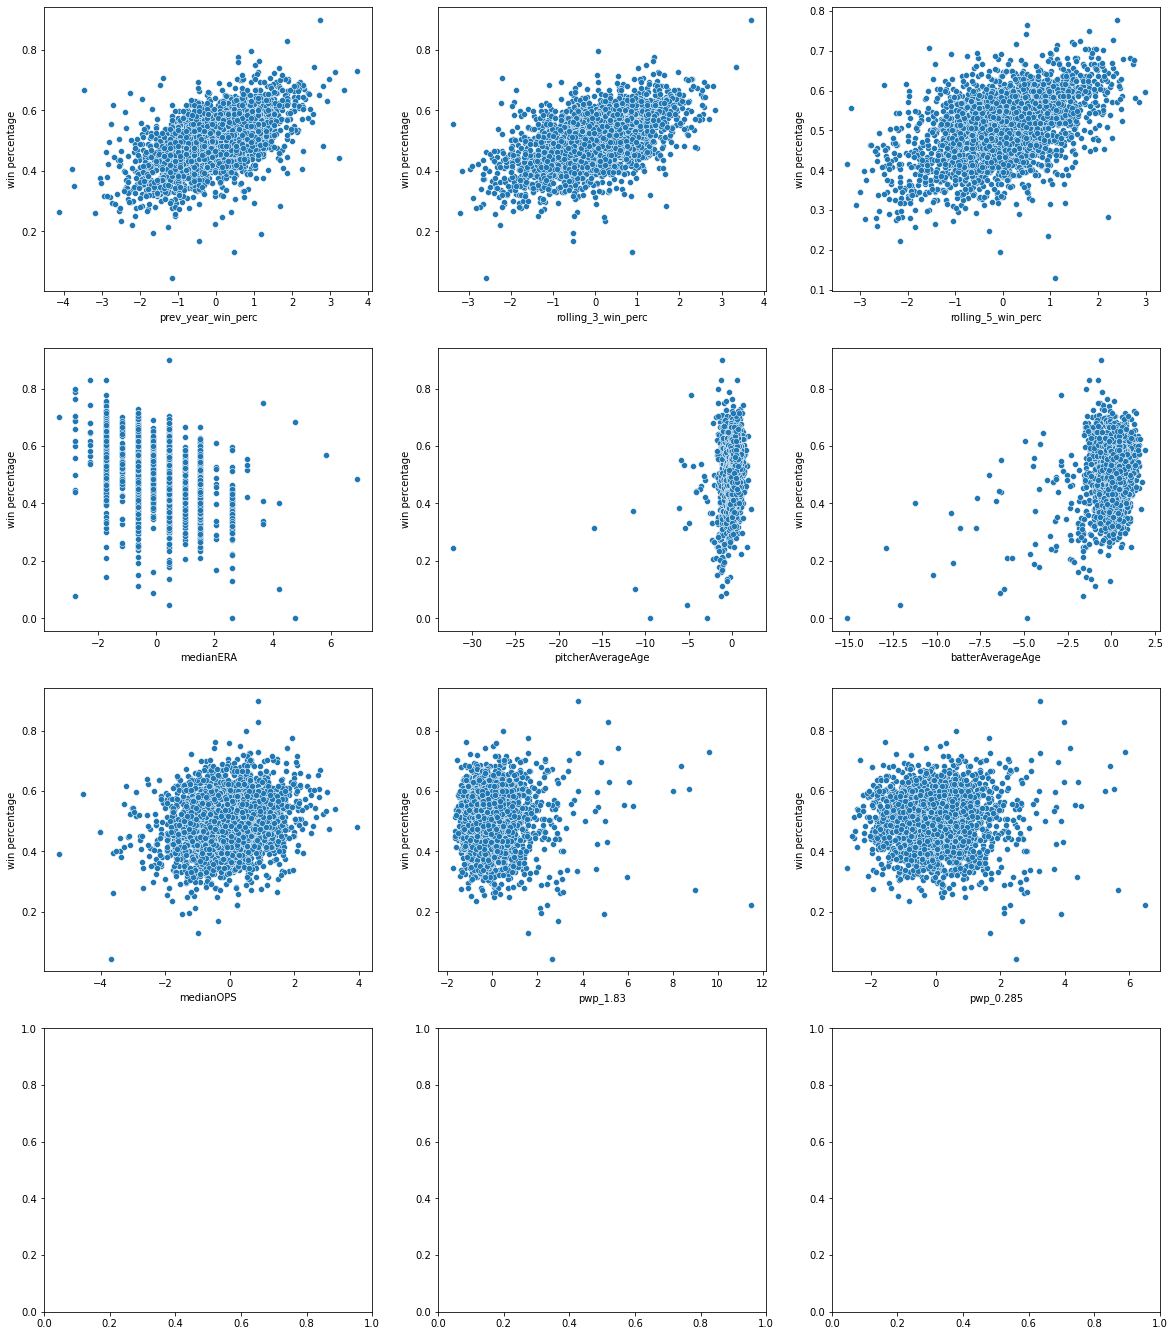

In [52]:
columns = ['prev_year_win_perc', 'rolling_3_win_perc',
       'rolling_5_win_perc', 'medianERA', 'pitcherAverageAge',
       'batterAverageAge', 'medianOPS', 'pwp_1.83', 'pwp_0.285']
import seaborn as sns

m = 4
n = int(np.ceil(len(columns)/4))
c = 0
fig, axes = plt.subplots(m,n, figsize = (20, 8*n))
for i in range(m):
  for j in range(n):
    if c>= len(columns): break
    sns.scatterplot(x = X[columns[c]], y = y, ax=axes[i,j])
    axes[i, j].set_ylabel('win percentage')
    c += 1
    
plt.show()

## Test/ train

In [28]:
#@title custom train test split
def train_test_split(X, y, train_size):
  # produces time separated test and train split of roughly the train_size passed into this method
  X_train, y_train = pd.DataFrame(), []
  X_test, y_test = pd.DataFrame(), []
  train_size = int(X.shape[0]*train_size)
  counts = X.groupby(['yearID'], sort=True)['yearID'].count()
  years_mm = list(set(X['yearID']))
  years_mm.sort()
  for i, count in enumerate(counts):
    X_train_ = X[X['yearID'] == i]
    idx = X_train_.index
    y_train_ = np.array(y)[idx]
    years_mm.pop(0)
    X_train = pd.concat([X_train, X_train_])
    y_train += list(y_train_)
    if X_train.shape[0] >= train_size:
      break

  for year in years_mm:
    X_test_ = X[X['yearID'] == year]
    idx = X_test_.index
    y_test_ = np.array(y)[idx]
    X_test = pd.concat([X_test, X_test_])
    y_test += list(y_test_)

  return (X_train, X_test, y_train, y_test)


In [29]:
from sklearn import dummy 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
clf = dummy.DummyRegressor(strategy='mean')
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

-0.0007190381786659206

## Model

In [30]:
# boost regression
reg_xgb = xgb.XGBRegressor(objective = 'reg:squarederror' )
reg_xgb.fit(X_train,y_train)

XGBRegressor(objective='reg:squarederror')

## Cross validation

In [31]:
#@title custom cross validation
# cross val

def cross_val(model, k):
  n_years = len(set(X_train['yearID']))
  years = list(set(X_train['yearID']))
  years.sort()
  if n_years%2 != k%2: k += 1
  print('k :', k) 
  size_k = int(n_years/k)
  splits = {}
  j = 0
  for i in range(k):
    splits[i] = years[j:j+size_k]
    j = j+size_k

  X_val_train_set = {}
  y_val_train_set = {}
  X_val_test_set = {}
  y_val_test_set = {}

  min_train_size = X_train.shape[0]
  min_test_size = X_test.shape[0]
  for i in range(k):
    val_set = splits[i]
    start_year = val_set[0]
    end_year = val_set[size_k - 1]
    
    X_val_test = X_train[(X_train['yearID'] >= start_year) & (X_train['yearID'] <= end_year)].copy()
    idx = X_val_test.index
    if len(idx) < min_test_size: min_test_size = len(idx)
    y_val_test = np.array(y)[idx]

    up = X_train[(X_train['yearID'] < start_year)]
    up = None if up.empty else up
    do = X_train[(X_train['yearID'] > end_year)]
    do = None if do.empty else do
    X_val_train =  pd.concat([up, do]).copy()
    idx = X_val_train.index
    if len(idx) < min_train_size: min_train_size = len(idx)
    y_val_train = np.array(y)[idx]

    X_val_test_set[i] = X_val_test
    X_val_train_set[i] = X_val_train
    y_val_test_set[i] = y_val_test
    y_val_train_set[i] = y_val_train

  scores = []
  min_test_size1 = int(min_train_size/k)
  min_test_size = min(min_test_size, min_test_size1)
  min_train_size = k*min_test_size
  for i in range(k):
    random_scores = []
    for j in range(3):
      idx_train = np.array(list(X_val_train_set[i].index)) 
      selected_idx = np.random.choice(len(idx_train), replace = False, size = min_train_size)
      y_val_train = y_val_train_set[i][selected_idx]
      selected_idx = idx_train[selected_idx]
      X_val_train = X_val_train_set[i].loc[selected_idx]

      idx_test = np.array(list(X_val_test_set[i].index)) 
      selected_idx = np.random.choice(len(idx_test), replace = False, size = min_test_size)
      y_val_test = y_val_test_set[i][selected_idx]
      selected_idx = idx_test[selected_idx]
      X_val_test = X_val_test_set[i].loc[selected_idx]
    
      model.fit(X_val_train, y_val_train)
      score = model.score(X_val_test, y_val_test)
      random_scores.append(score)
    scores.append(np.mean(random_scores))

  return np.array(scores)
    
score = cross_val(reg_xgb, 5).mean()
print(score)


k : 6
0.432589875966781


## Testing

In [32]:
y_pred = reg_xgb.predict(X_test)
score = reg_xgb.score(X_test, y_test)
print(score)

0.3980565978466071


## Result visualization

In [33]:
inv = list(ohe.inverse_transform(X_test[tid_names]).reshape(1,-1))[0]
test_years = list(X_test['yearID'])

result_df = pd.DataFrame()
result_df['yearID'] = np.array(year_array)[test_years]
result_df['teamID'] = inv
result_df['win_prob_pred'] = list(y_pred)
result_df['win_prob_pred'] *= 100
result_df['win_prob_actual'] = list(y_test)
result_df['win_prob_actual'] *= 100


result_df

,yearID,teamID,win_prob_pred,win_prob_actual
0,2003,ANA,53.463375,47.530864
1,2003,ARI,55.611195,51.851852
2,2003,ATL,61.901604,62.345679
3,2003,BAL,42.679798,43.827160
4,2003,BOS,53.118633,58.641975
...,...,...,...,...
565,2021,SLN,49.443741,55.555556
566,2021,TBA,62.077011,61.728395
567,2021,TEX,41.360603,37.037037
568,2021,TOR,50.062687,56.172840


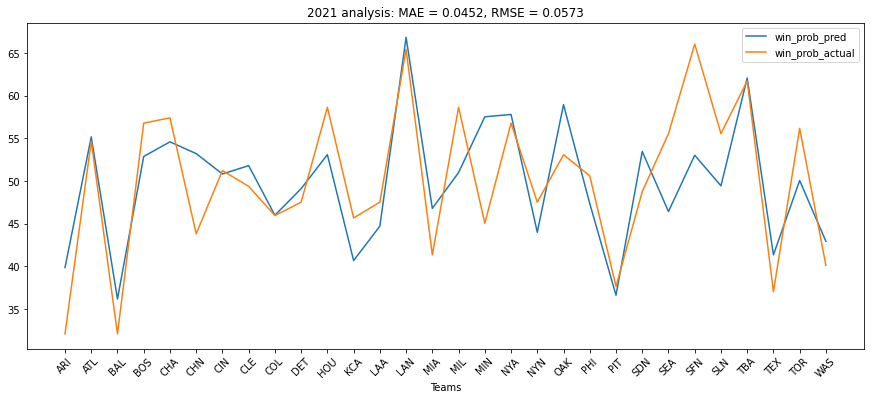

In [34]:
#@title graph for 2021 
mae = metrics.mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
result_df_2021 = result_df[result_df['yearID'] == 2021 ]
plt.figure(figsize = (15,6))
plt.plot(result_df_2021['teamID'], result_df_2021['win_prob_pred'], label = 'win_prob_pred')
plt.plot(result_df_2021['teamID'], result_df_2021['win_prob_actual'], label = 'win_prob_actual')
plt.title(f'2021 analysis: MAE = {round(mae, 4)}, RMSE = {round(rmse, 4)}')
plt.xlabel('Teams')
plt.xticks(rotation=45)
plt.legend()
plt.show()

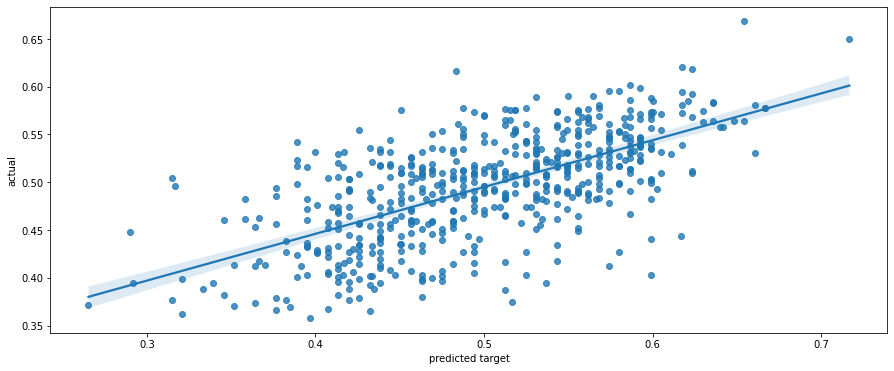

In [35]:
#@title predicted vs actual

import seaborn as sns

plt.figure(figsize=(15, 6))
sns.regplot(x = y_test, y = y_pred)
plt.xlabel('predicted target')
plt.ylabel('actual')
plt.show()

#### shap import and values

In [36]:
%%capture
!pip install shap
import shap

explainer = shap.Explainer(reg_xgb)
shap_values = explainer(X_test)

#### plots

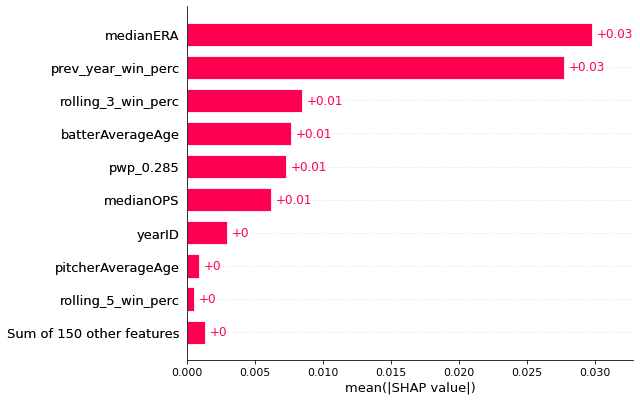

In [37]:
shap.plots.bar(shap_values, max_display=10) 

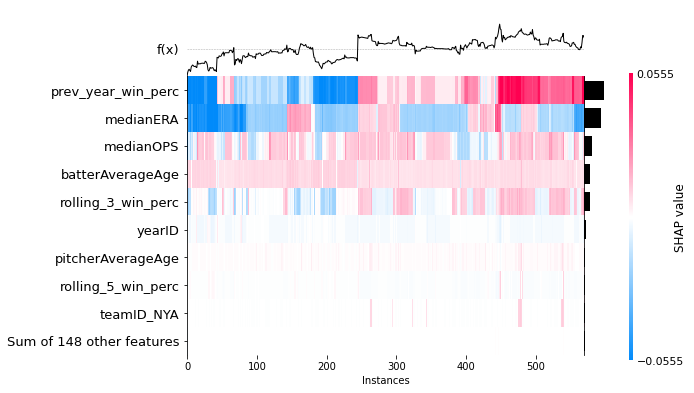

In [ ]:
shap.plots.heatmap(shap_values)

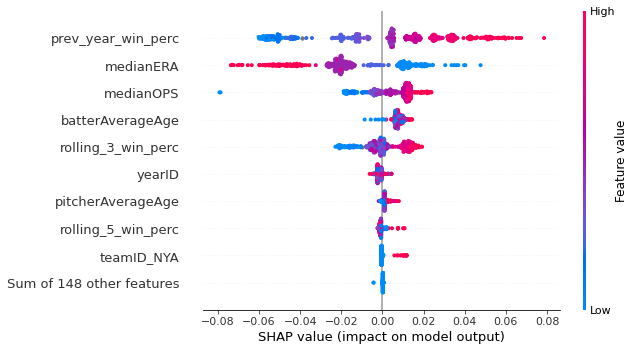

In [ ]:
shap.plots.beeswarm(shap_values)

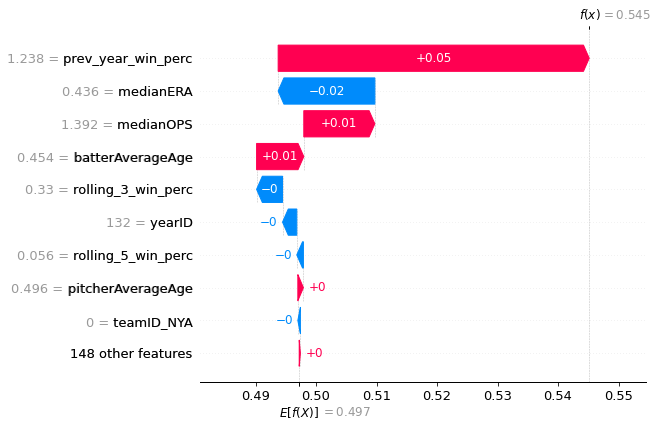

In [ ]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

## other basic models 

In [ ]:
imputer_mean = impute.SimpleImputer()
X_train_ = imputer_mean.fit_transform(X_train)
X_test_ = imputer_mean.transform(X_test)

In [ ]:
#@title linear regression

reg1 = linear_model.LinearRegression()
reg1.fit(X_train_, y_train)
y_pred1 = reg1.predict(X_test_)
print(metrics.r2_score(y_test, y_pred1))

0.341971073352618


In [ ]:
#@title decision tree
reg2 = tree.DecisionTreeRegressor()
reg2.fit(X_train_, y_train)
y_pred2 = reg2.predict(X_test_)
print(metrics.r2_score(y_test, y_pred2))

-0.34794073825518157
